In [7]:
import pymupdf
import cv2
import numpy as np
import pytesseract
import translators as ts
from PIL import Image, ImageDraw, ImageFont
import io
import os
import sys
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath('..'))

from src.image_processor import preprocess_image_for_ocr


# Fix

## v0b.1

- Stacks:
1. OCR -> Surya
2. Translate ->
3. Serving -> FastAPI

# exp

Found 277 potential text boxes.
dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])
Detected text: 
Detected text: 
Detected text: 
Detected text: 
Detected text:  
Detected text: 
Detected text: 
Detected text: 
Detected text: -
Detected text: مثال
Detected text: الأول:
Detected text: أن
Detected text: يقول:
Detected text: والله
Detected text: لا
Detected text: أكلم
Detected text: أحدّاء
Detected text: ونوئ
Detected text: زيداء
Detected text: قصر
Detected text: 
Detected text: 
Detected text: 
Detected text: -
Detected text: مثال
Detected text: الثاني:
Detected text: أن
Detected text: يمنّ
Detected text: عليه
Detected text: رجل
Detected text: بما
Detected text: نال
Detected text: منهء
Detected text: فيقول:
Detected text: والله
Detected text: لا
Detected text: 
Detected text: أشرب
Detected text: منه
Detected text: ماء
Detected text: من
Detected text: عطش
Detected text: »
Detected text: فإن
Detected text: الي

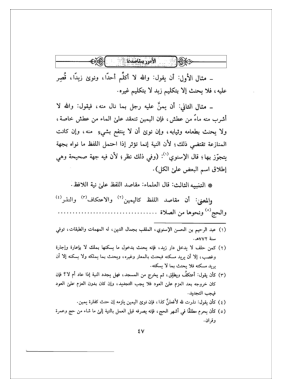

In [13]:
doc = pymupdf.open("../examples/idhah-qawaid-1-page.pdf")

modified_images = []
for i, page in enumerate(doc):
    # 1. Convert page to a high-resolution image
    pix = page.get_pixmap(dpi=300)
    img_data = pix.tobytes("png")
    image = Image.open(io.BytesIO(img_data))
    draw = ImageDraw.Draw(image)


    # 2. Perform Arabic OCR to get text and bounding boxes
    ocr_data = pytesseract.image_to_data(
        image, lang='ara', output_type=pytesseract.Output.DICT
    )

    n_boxes = len(ocr_data['level'])
    print(f"Found {n_boxes} potential text boxes.")
    print(ocr_data.keys())

    for text in ocr_data['text']:
        print(f"Detected text: {text}")

    for box in ocr_data['level']:
        (x, y, w, h) = (
            ocr_data['left'][box-1],
            ocr_data['top'][box-1],
            ocr_data['width'][box-1],
            ocr_data['height'][box-1]
        )
        draw.rectangle([x, y, x + w, y + h], outline='red', width=2)

    preprocessed_image = preprocess_image_for_ocr(image)

    plt.imshow(cv2.cvtColor(np.array(preprocessed_image), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # # ax, fig = plt.subplots(1, 2, figsize=(12, 16))

    # # plt.subplot(1, 2, 1)
    # plt.imshow(image)
    # plt.axis('off')
    
    # plt.subplot(1, 2, 2)
    # plt.imshow(draw)
    # plt.axis('off')
    
    # plt.show()
    
#     # 3. Translate and overlay text
#     for j in range(n_boxes):
#         # We only care about actual words
#         if int(ocr_data['conf'][j]) > 40: # Filter by confidence level
#             text = ocr_data['text'][j].strip()
#             if not text:
#                 continue

#             # Get bounding box coordinates
#             (x, y, w, h) = (
#                 ocr_data['left'][j],
#                 ocr_data['top'][j],
#                 ocr_data['width'][j],
#                 ocr_data['height'][j]
#             )

#             # 4. Translate the detected Arabic text
#             print(f"Translating '{text}'...")
#             translated_text = translate_text_with_retry(text, target_language)
#             print(f" -> '{translated_text}'")

#             # 5. Overlay: Cover original text and draw translated text
#             # Cover original text with a white rectangle
#             draw.rectangle([x, y, x + w, y + h], fill='white', outline='white')

#             # Dynamically adjust font size to fit the box width
#             font_size = h
#             font = ImageFont.truetype(font_path, font_size)
#             # Reduce font size until text fits within the original width
#             while font.getbbox(translated_text)[2] > w and font_size > 8:
#                 font_size -= 1
#                 font = ImageFont.truetype(font_path, font_size)

#             # Draw the translated text
#             draw.text((x, y), translated_text, font=font, fill='black')

#     modified_images.append(image)
#     print(f"--- Page {i+1} processed. ---")

# # 6. Save the modified images into a new PDF
# if modified_images:
#     print(f"\nSaving translated pages to new PDF: {output_pdf_path}")
#     modified_images[0].save(
#         output_pdf_path,
#         save_all=True,
#         append_images=modified_images[1:],
#         resolution=300.0
#     )
#     print("Translation complete!")
# else:
#     print("No pages were processed. Output PDF not created.")

# doc.close()

In [15]:
def translate_text_with_retry(text, target_language='indonesian'):
    """
    Translates a given text to the target language.
    Includes a retry mechanism with a different translation service if the default fails.
    """
    if not text or not text.strip():
        return ""
    try:
        # Using the 'google' translator by default
        return ts.translate_text(text, translator='google', to_language=target_language)
    except Exception as e:
        print(f"Google translator failed: {e}. Trying with 'bing'.")
        try:
            # Fallback to 'bing' translator
            return ts.translate_text(text, translator='bing', to_language=target_language)
        except Exception as e2:
            print(f"Bing translator also failed: {e2}. Returning original text.")
            return text # Return original text if all translators fail

def process_pdf_and_translate(
    input_pdf_path,
    output_pdf_path,
    
    font_path="arial.ttf",
    target_language='id'
):
    """
    Processes a PDF file by performing OCR on each page, translating the text,
    and creating a new PDF with the translated text overlaid.

    Args:
        input_pdf_path (str): Path to the source Arabic PDF file.
        output_pdf_path (str): Path to save the translated PDF file.
        font_path (str): Path to the .ttf font file for writing translated text.
        target_language (str): Target language code (e.g., 'id' for Indonesian).
    """
    if not os.path.exists(font_path):
        print(f"Error: Font file not found at '{font_path}'. Please provide a valid path.")
        return

    print(f"Opening PDF: {input_pdf_path}")
    doc = pymupdf.open(input_pdf_path)
    modified_images = []

    print(f"Processing {len(doc)} pages...")
    for i, page in enumerate(doc):
        print(f"--- Processing Page {i+1}/{len(doc)} ---")

        # 1. Convert page to a high-resolution image
        pix = page.get_pixmap(dpi=300)
        img_data = pix.tobytes("png")
        image = Image.open(io.BytesIO(img_data))
        draw = ImageDraw.Draw(image)

        # 2. Perform Arabic OCR to get text and bounding boxes
        print("Performing OCR to detect Arabic text...")
        # Use image_to_data to get bounding box info for each word
        ocr_data = pytesseract.image_to_data(
            image, lang='ara', output_type=pytesseract.Output.DICT
        )

        n_boxes = len(ocr_data['level'])
        print(f"Found {n_boxes} potential text boxes.")

        # 3. Translate and overlay text
        for j in range(n_boxes):
            # We only care about actual words
            if int(ocr_data['conf'][j]) > 40: # Filter by confidence level
                text = ocr_data['text'][j].strip()
                if not text:
                    continue

                # Get bounding box coordinates
                (x, y, w, h) = (
                    ocr_data['left'][j],
                    ocr_data['top'][j],
                    ocr_data['width'][j],
                    ocr_data['height'][j]
                )

                # 4. Translate the detected Arabic text
                print(f"Translating '{text}'...")
                translated_text = translate_text_with_retry(text, target_language)
                print(f" -> '{translated_text}'")

                # 5. Overlay: Cover original text and draw translated text
                # Cover original text with a white rectangle
                draw.rectangle([x, y, x + w, y + h], fill='white', outline='white')

                # Dynamically adjust font size to fit the box width
                font_size = h
                font = ImageFont.truetype(font_path, font_size)
                # Reduce font size until text fits within the original width
                while font.getbbox(translated_text)[2] > w and font_size > 8:
                    font_size -= 1
                    font = ImageFont.truetype(font_path, font_size)

                # Draw the translated text
                draw.text((x, y), translated_text, font=font, fill='black')

        modified_images.append(image)
        print(f"--- Page {i+1} processed. ---")

    # 6. Save the modified images into a new PDF
    if modified_images:
        print(f"\nSaving translated pages to new PDF: {output_pdf_path}")
        modified_images[0].save(
            output_pdf_path,
            save_all=True,
            append_images=modified_images[1:],
            resolution=300.0
        )
        print("Translation complete!")
    else:
        print("No pages were processed. Output PDF not created.")

    doc.close()

# # --- Execution ---
# if __name__ == "__main__":
#     # --- USER: Please update these paths ---
#     INPUT_PDF = "arabic_document.pdf"  # The name of your source PDF
#     OUTPUT_PDF = "translated_document_id.pdf" # The name for the output PDF
#     FONT_FILE = "arial.ttf" # Path to your font file
#     TARGET_LANG = "id" # Target language code for Indonesian

#     if not os.path.exists(INPUT_PDF):
#         print(f"Error: Input file not found at '{INPUT_PDF}'.")
#         print("Please make sure the file exists and the path is correct.")
#     else:
#         process_pdf_and_translate(
#             input_pdf_path=INPUT_PDF,
#             output_pdf_path=OUTPUT_PDF,
#             font_path=FONT_FILE,
#             target_language=TARGET_LANG
#         )

In [ ]:
%cd /Users/rizkyagung/Documents/projects/tarjim

INPUT_PDF = "examples/ifadatul-mustafid-1-page.pdf"  # The name of your source PDF
OUTPUT_PDF = INPUT_PDF.split(".")[0] + "_id_v_0b_0.pdf" # The name for the output PDF
FONT_FILE = "fonts/times.ttf" # Path to your font file
TARGET_LANG = "id" # Target language code for Indonesian

if not os.path.exists(INPUT_PDF):
    print(f"Error: Input file not found at '{INPUT_PDF}'.")
    print("Please make sure the file exists and the path is correct.")
else:
    process_pdf_and_translate(
        input_pdf_path=INPUT_PDF,
        output_pdf_path=OUTPUT_PDF,
        font_path=FONT_FILE,
        target_language=TARGET_LANG
    )

/Users/rizkyagung/Documents/projects/tarjim
Opening PDF: examples/ifadatul-mustafid-1-page.pdf
Processing 1 pages...
--- Processing Page 1/1 ---
Performing OCR to detect Arabic text...
Found 233 potential text boxes.
Translating 'مقدمة'...
 -> 'perkenalan'
Translating 'الشارح'...
 -> 'Penjelasan'
Translating 'مقدمة'...
 -> 'perkenalan'
Translating 'الشارح'...
 -> 'Penjelasan'
Translating '010'...
 -> '010'
Translating 'وأصحابه'...
 -> 'dan teman-temannya'
Translating 'أجمعين.'...
 -> 'Setiap orang.'
Translating 'أما'...
 -> 'Adapun'
Translating 'بعد:'...
 -> 'setelah:'
Translating 'فإن'...
 -> 'Itu'
Translating 'التوحيد'...
 -> 'Monoteisme'
Translating 'وهو:'...
 -> 'Yang:'
Translating 'إفراد'...
 -> 'Jomblo'
Translating 'الله'...
 -> 'Tuhan'
Translating 'بالعبادة'...
 -> 'Dengan beribadah'
Translating 'وترك'...
 -> 'Dan pergi'
Translating 'عبادة'...
 -> 'memuja'
Translating 'ما'...
 -> 'Apa'
Translating 'سواه'...
 -> 'Selain dia'
Translating 'هو'...
 -> 'Dia'
Translating 'أول'...
 -> 